# Worksheet 13

Name: Shu Xing
UID: U97658230

### Topics

- Support Vector Machines

## Support Vector Machines

a) Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

# Dataset
X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

# Initializing w and b
w = np.array([1, 1])
b = 0.1

# Perceptron Parameters
epochs = 100
alpha = .05
expanding_rate = .99
retracting_rate = 1.1

def snap(x, w, b, error):
    """
        Plot the street induced by w and b.
        Circle the point x in red if it was
        misclassified or in yellow if it was
        classified correctly.
    """

    xplot = np.linspace(-3, 3)
    cs = np.array([x for x in 'gb'])

    svm = (-w[0] * xplot - b) / w[1]
    left_svm = (-w[0] * xplot - b - 1) / w[1]
    right_svm = (-w[0] * xplot - b + 1) / w[1]

    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)
    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .2, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .2, color='y',fill=False))
    ax.plot(xplot, left_svm, 'g--', lw=2)
    ax.plot(xplot, svm, 'r-', lw=2)
    ax.plot(xplot, right_svm, 'b--', lw=2)
    ax.set_xlim(min(X[:, 0]) - 1, max(X[:,0]) + 1)
    ax.set_ylim(min(X[:, 1]) - 1, max(X[:,1]) + 1)
    fig.savefig(TEMPFILE)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE)))


images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, X.shape[0])
    x, y = X[i], Y[i]
    error = False

    # calculate the activation of the perceptron
    a = np.dot(w, x) + b

    # update the weights and bias if the prediction is incorrect
    if y * a <= 0:
        w = w + alpha * y * x
        b = b + alpha * y
        error = True   
    images.append(snap(x, w, b, error))

images[0].save(
    'svm.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

b) Consider the following dataset:

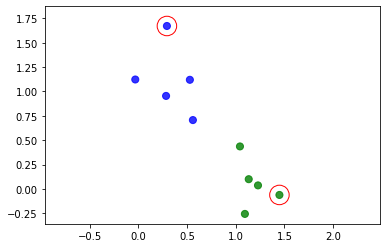

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

centers = [[0, 1], [1, 0]]
X, _ = datasets.make_blobs(n_samples=10, centers=centers, cluster_std=0.3, random_state=0)
Y = np.array([1 if x[0] - x[1] >= 0 else 0 for x in X])

cs = np.array([x for x in 'bg'])
_, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],color=cs[Y].tolist(), s=50, alpha=0.8)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(plt.Circle((X[0][0], X[0][1]), .1, color='r',fill=False))
ax.add_patch(plt.Circle((X[1][0], X[1][1]), .1, color='r',fill=False))
plt.show()

if we fit an SVM to the above dataset, moved the points circled in red, and re-fit the SVM, describe how the fit would change depending on how the points are moved.

If the points are moved towards the other class, the hyperplane's position may shift towards the opposite direction. On the other hand, if the points are moved away from the other class, the hyperplane's position may move towards the same direction.

c) If we were to fit an SVM to the above dataset, which points do you think would affect the decision boundary the most? Circle them in red.

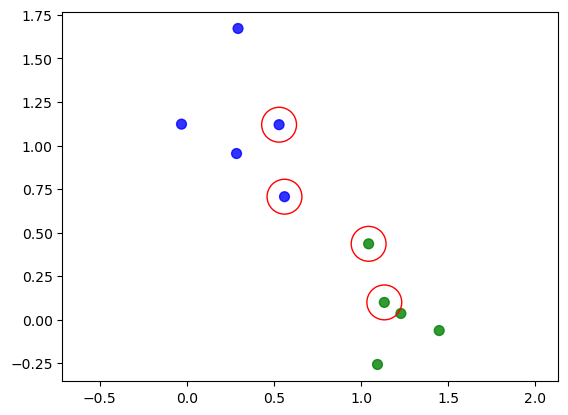

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
from sklearn.svm import SVC

# Generate dataset
centers = [[0, 1], [1, 0]]
X, _ = datasets.make_blobs(n_samples=10, centers=centers, cluster_std=0.3, random_state=0)
Y = np.array([1 if x[0] - x[1] >= 0 else 0 for x in X])

# Fit SVM
clf = SVC(kernel='linear')
clf.fit(X, Y)

# Identify support vectors
support_vectors = clf.support_vectors_

# Plot dataset and support vectors
cs = np.array([x for x in 'bg'])
_, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],color=cs[Y].tolist(), s=50, alpha=0.8)
ax.set_aspect('equal', adjustable='datalim')
for i in range(len(X)):
    if X[i] in support_vectors:
        ax.add_patch(plt.Circle((X[i][0], X[i][1]), .1, color='r',fill=False))
plt.show()

d) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [3]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def predict(alpha_i, b, x):
    prediction = b
    for i in range(len(alpha_i)):
        prediction += alpha_i[i] * Y[i] * np.dot(X[i], x)
    return prediction


images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    
    prediction = predict(alpha_i, b, x)
    if y*prediction <= 0:
        error = True
        alpha_i[i] += learning_rate * y
        b += learning_rate * y
    else:
        alpha_i[i] *= expanding_rate
        b *= retracting_rate
        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

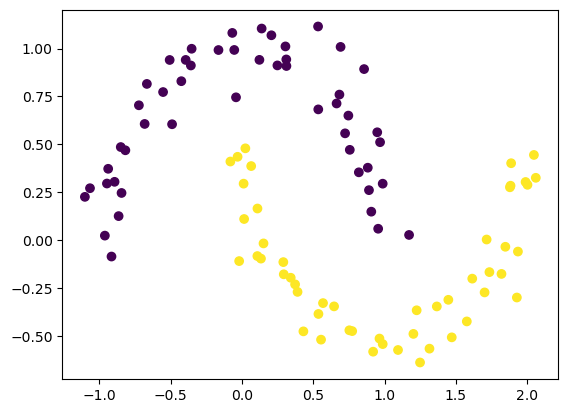

In [15]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# Generate non-linearly separable dataset
X, y = make_moons(n_samples=100, noise=0.1, random_state=0)

# Plot dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()



e) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

Adjust the regularization parameter C. A higher value of C will increase the penalty for misclassifications and result in a more complex decision boundary, while a lower value of C will allow more misclassifications but result in a simpler decision boundary that generalizes better.

f) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

Try increasing the value of sigma to make the decision boundary more wiggly and complex. This allows the model to fit more closely to the training data, potentially improving its predictive performance.

g) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.857 total time=   0.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.893 total time=   0.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.929 total time=   0.0s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.964 total time=   0.0s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.893 total time=   0.0s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.821 total time=   0.0s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.786 total time=   0.0s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.786 total time=   0.0s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.786 total time=   0.0s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.714 total time=   0.0s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.500 total time=   0.0s
[CV 2/5] END .................C=0.1, gamma=0.01;

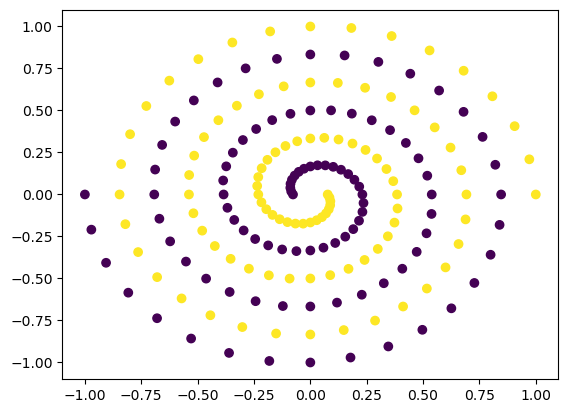

In [21]:

import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

plt.scatter(x[:,0], x[:,1], c=y)

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, verbose=3)
grid.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(grid.best_params_)
print()
print("Grid scores on development set:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, grid.predict(X_test)
print(classification_report(y_true, y_pred))
print()
